# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in [breast cancer demo](./breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform multi-class logistic classification
* Create a confusion matrix
* Use L1-regularization for improved estimation in the case of sparse weights (Grad students only)

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Use the `pd.read_excel` command to read the data from 

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [2]:
# TODO
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/'+
                   '00342/Data_Cortex_Nuclear.xls',
                   header=None,na_values='?')
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header
df = df.set_index('MouseID')
df.head(6)

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.81633,5.99015,0.21883,0.177565,2.37374,0.232224,1.75094,...,0.108336,0.427099,0.114783,0.13179,0.128186,1.67565,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.41177,2.78951,5.68504,0.211636,0.172817,2.29215,0.226972,1.59638,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.74361,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.6872,5.62206,0.209011,0.175722,2.28334,0.230247,1.56132,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.92643,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.46695,4.9795,0.222886,0.176463,2.1523,0.207004,1.59509,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.70056,Control,Memantine,C/S,c-CS-m
309_5,0.43494,0.61743,0.358802,2.36578,4.71868,0.213106,0.173627,2.13401,0.192158,1.50423,...,0.110694,0.434154,0.118481,0.140314,0.14838,1.83973,Control,Memantine,C/S,c-CS-m
309_6,0.447506,0.628176,0.367388,2.38594,4.80764,0.218578,0.176233,2.14128,0.195188,1.4424,...,0.109446,0.439833,0.116657,0.140766,0.14218,1.81639,Control,Memantine,C/S,c-CS-m


This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [3]:
# TODO
df1 = df.fillna(df.mean())

## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [4]:
# TODO
yraw = df1['Genotype'].values
label, indices = np.unique(yraw, return_inverse=True)
BEN_VAL = label[0]
MAL_VAL = label[1]
y = (yraw == MAL_VAL).astype(int)
Iben = (y==0)
Imal = (y==1)

As predictors, get all but the last four columns of the dataframes.  Standardize the data matrix and call the standardized matrix `Xs`.  The predictors are the expression levels of the 77 genes. 

In [5]:
# TODO
xnames = new_header[1:78].values
X = np.array(df1[xnames])
Xs = preprocessing.scale(X)

Create a `LogisticRegression` object `logreg` and `fit` the training data.

In [6]:
# TODO
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(Xs, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Measure the accuracy of the classifer.  That is, use the `logreg.predict` function to predict labels `yhat` and measure the fraction of time that the predictions match the true labels.  Below, we will properly measure the accuracy on cross-validation data.

In [7]:
# TODO
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 1.000000


## Interpreting the weight vector

Create a stem plot of the coefficients, `W` in the logistic regression model.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

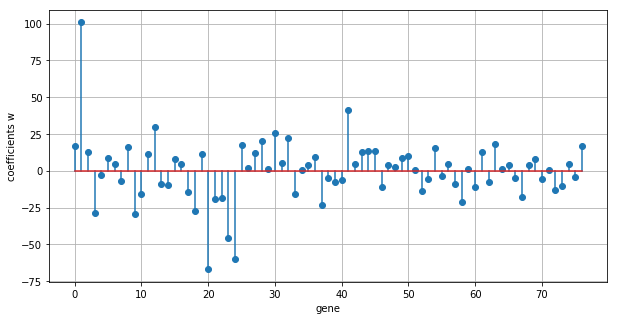

In [8]:
# TODO
w = np.squeeze(logreg.coef_)
plt.figure(1)
plt.figure(figsize=(10,5))
plt.stem(w)
plt.xlabel('gene')
plt.ylabel('coefficients w')
plt.grid(True)

You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.  Although, we do not discuss it in this class, there are ways to force the logistic regression to return a sparse vector `W`.  

Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [9]:
# TODO
d = 2  # Number of neurons to use
Isel_o = np.argsort(w)
Isel = []
genes = []
for i in range (d):
    Isel.append(Isel_o[Isel_o.shape[0]-i-1])
    genes.append(xnames[Isel[i]])
print("The index i of the genes where the magnitude of W[i] is largest = ", Isel[0:])
print("The names of the genes where the magnitude of W[i] is largest = ", genes[0:])

The index i of the genes where the magnitude of W[i] is largest =  [1, 41]
The names of the genes where the magnitude of W[i] is largest =  ['ITSN1_N', 'TIAM1_N']


## Cross Validation

The above meaured the accuracy on the training data.  It is more accurate to measure the accuracy on the test data.  Perform 10-fold cross validation and measure the average precision, recall and f1-score.  Note, that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall and f1-score and error rate across all the folds.

In [10]:
# TODO
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
prec = []
rec = []
f1 = []
acc = []
for train, test in kf.split(Xs):            
    # Get training and test data
    Xtr = Xs[train,:]
    ytr = y[train]
    Xts = Xs[test,:]
    yts = y[test]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    # Measure performance
    preci,reci,f1i,_= precision_recall_fscore_support(yts,yhat,average='binary') 
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    acci = np.mean(yhat == yts)
    acc.append(acci)

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

# Compute the standard errors
prec_se = np.std(prec)/np.sqrt(nfold-1)
rec_se = np.std(rec)/np.sqrt(nfold-1)
f1_se = np.std(f1)/np.sqrt(nfold-1)
acc_se = np.std(acc)/np.sqrt(nfold-1)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

Precision = 0.9403, SE=0.0141
Recall =    0.9572, SE=0.0080
f1 =        0.9481, SE=0.0090
Accuracy =  0.9509, SE=0.0082


## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  Use the `np.unique` funtion as before to convert this to a vector `y` with values 0 to 7.

In [11]:
# TODO
yraw1 = df1['class'].values
label1, indices = np.unique(yraw1, return_inverse=True)
y1 = []
for i in range(0,len(yraw1)):
    for j in range(0,len(label1)):
        if yraw1[i] == label1[j]:
            y1.append(j)
y1 = np.array(y1)

Fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method.

In [12]:
# TODO
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(Xs, y1)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Measure the accuracy on the training data.

In [13]:
# TODO
y1hat = logreg.predict(Xs)
acc1 = np.mean(y1hat == y1)
print("Accuracy on training data = %f" % acc1)

Accuracy on training data = 1.000000


Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold. You can use the `confustion_matrix` method in the `sklearn` package.  Add the confusion matrix counts across all folds and then normalize the rows of the confusion matrix so that they sum to one.  Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`.  Print the confusion matrix.  You can use the command

    print(np.array_str(C, precision=4, suppress_small=True))
    
to create a nicely formatted print.  Also print the overall mean and SE of the test error rate across the folds.

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# TODO
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
acc = []
c = np.empty((8,8))
for train, test in kf.split(Xs):            
    # Get training and test data
    Xtr = Xs[train,:]
    ytr = y1[train]
    Xts = Xs[test,:]
    yts = y1[test]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    # count confusion matrix
    c = c + confusion_matrix(yts, yhat)
    
    # calculate test error rate
    acci = np.mean(yhat == yts)
    acc.append(acci)

c_normalized = c.astype('float') / c.sum(axis=1)[:, np.newaxis]
print(np.array_str(c_normalized, precision=4, suppress_small=True))

accm= np.mean(acc)
acc_se = np.std(acc)/np.sqrt(nfold-1)
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

[[ 0.9733  0.0267  0.      0.      0.      0.      0.      0.    ]
 [ 0.0222  0.9704  0.      0.      0.0074  0.      0.      0.    ]
 [ 0.      0.0067  0.98    0.0133  0.      0.      0.      0.    ]
 [ 0.0074  0.      0.      0.9852  0.0074  0.      0.      0.    ]
 [ 0.      0.0074  0.      0.      0.9926  0.      0.      0.    ]
 [ 0.0095  0.      0.      0.      0.      0.9905  0.      0.    ]
 [ 0.      0.      0.      0.0074  0.      0.      0.9926  0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      1.    ]]
Accuracy =  0.9852, SE=0.0034


Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes.

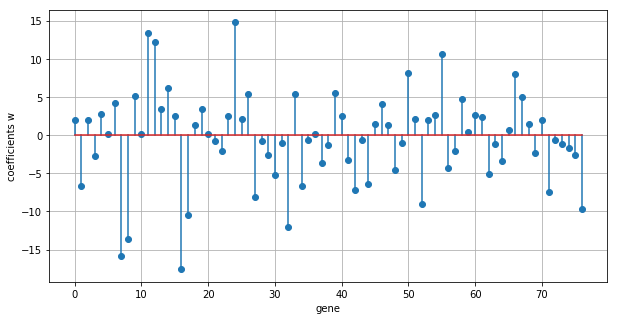

In [15]:
# TODO
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(Xs, y1)
w1 = np.squeeze(logreg.coef_)
w1r1 = w1[0,:]
plt.figure(2)
plt.figure(figsize=(10,5))
plt.stem(w1r1)
plt.xlabel('gene')
plt.ylabel('coefficients w')
plt.grid(True)

## L1-Regularization

Graduate students only complete this section.

In most genetic problems, only a limited number of the tested genes are likely influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [prostate cancer analysis demo](../model_sel/prostate.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation 
* You should select around 20 values of `C`.  It is up to you find a good range.
* Make appropriate plots and print out to display your results
* How does the accuracy compare to the accuracy achieved without regularization.

In [16]:
# TODO
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)

C = [float("1e%d" %i) for i in range(-10,10)]

testacc = np.zeros((len(C),nfold))
testerr = np.zeros((len(C),nfold))

for ifold, ind in enumerate(kf.split(Xs)):
    
    Itr,Its = ind
    Xtr = Xs[Itr,:]
    ytr = y1[Itr]
    Xts = Xs[Its,:]
    yts = y1[Its]
    
    for ic, c in enumerate(C):
        clf = linear_model.LogisticRegression(penalty='l1', C=c)
        clf.fit(Xtr,ytr)
        
        yhat = logreg.predict(Xts)
        
        testacc[ic,ifold] = clf.score(Xts, yts)
        testerr[ic,ifold] = 1 - testacc[ic,ifold]

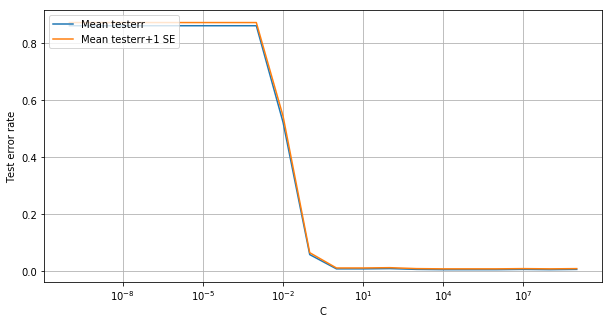

In [17]:
# Compute the mean and standard deviation over the different folds.
testerr_mean = np.mean(testerr,axis=1)
testerr_std = np.std(testerr,axis=1) / np.sqrt(nfold-1)

# Plot the mean MSE and the mean MSE + 1 std dev
plt.figure(3)
plt.figure(figsize=(10,5))
plt.semilogx(C, testerr_mean)
plt.semilogx(C, testerr_mean+testerr_std)
plt.legend(['Mean testerr', 'Mean testerr+1 SE'],loc='upper left')
plt.xlabel('C')
plt.ylabel('Test error rate')
plt.grid()
plt.show()

Optimal c = 1000.000000
Optimal Accuracy = 0.992593


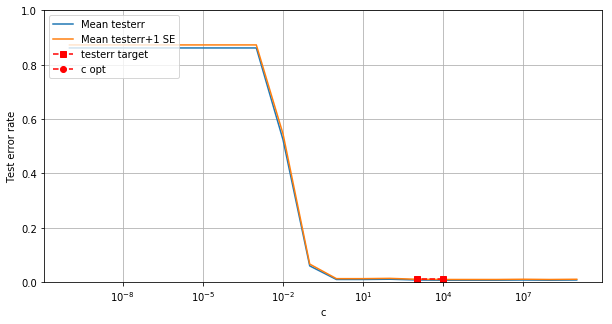

In [18]:
# Find the minimum MSE and MSE target
imin = np.argmin(testerr_mean)
testerr_tgt = testerr_mean[imin] + testerr_std[imin]
c_min = C[imin]

# Find the least complex model with mse_mean < mse_tgt
I = np.where(testerr_mean < testerr_tgt)[0]
iopt = I[0]
c_opt = C[iopt]
print("Optimal c = %f" % c_opt)
testacc_mean = np.mean(testacc,axis=1)
print("Optimal Accuracy = %f" % testacc_mean[iopt])

plt.figure(4)
plt.figure(figsize=(10,5))
# Plot the mean MSE and the mean MSE + 1 std dev
plt.semilogx(C, testerr_mean)
plt.semilogx(C, testerr_mean+testerr_std)

# Plot the MSE target
plt.semilogx([c_min,c_opt], [testerr_tgt,testerr_tgt], 'rs--')

# Plot the optimal alpha line
plt.semilogx([c_opt,c_opt], [0,testerr_mean[iopt]], 'ro--')

plt.legend(['Mean testerr', 'Mean testerr+1 SE', 'testerr target','c opt'],loc='upper left')
plt.xlabel('c')
plt.ylabel('Test error rate')
plt.ylim([0,1])
plt.grid()
plt.show()

For the optimal `C`, fit the model on the entire training data with l1 regularization. Find the resulting weight matrix, `W_l1`.  Plot the first row of this weight matrix and compare it to the first row of the weight matrix without the regularization.  You should see that, with l1-regularization, the weight matrix is much more sparse and hence the roles of particular genes are more clearly visible.

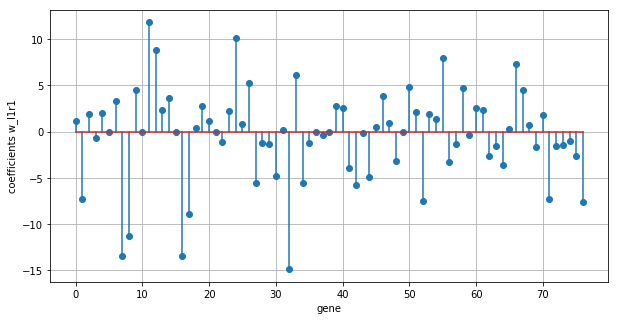

In [19]:
# TODO
logreg = linear_model.LogisticRegression(penalty='l1', C=c_opt)
logreg.fit(Xs, y1)
w_l1 = np.squeeze(logreg.coef_)
w_l1r1 = w_l1[0,:]
plt.figure(5)
plt.figure(figsize=(10,5))
plt.stem(w_l1r1)
plt.xlabel('gene')
plt.ylabel('coefficients w_l1r1')
plt.grid(True)